In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches import PathPatch
import numpy as np
import dill
import scipy.io
%matplotlib inline

In [2]:
# Set up global matplotlib params. 
matplotlib.rc('font',family='serif')
matplotlib.rc('text', usetex=True)
# matplotlib.rc('font',family='serif', serif=['Times'])

# Two Player Zero Sum

In [148]:
# Load the ILQG data.
# fp = open('../python/logs/two_player_zero_sum/goal_75_100_init_pi_2_5_v_5_dist.pkl', 'rb')
fp = open('../python/logs/two_player_zero_sum/goal_75_100_init_pi_6_v_5_dist.pkl', 'rb')
ilqg_data_top = dill.load(fp)
fp.close()

# fp = open('../python/logs/two_player_zero_sum/goal_75_100_init_pi_10_v_10.pkl', 'rb')
# ilqg_data_bottom = dill.load(fp)
# fp.close()

# Load the HJI data. 
hji_data_top = scipy.io.loadmat('../python/logs/unicycle_4d_reach_avoid_example_wMax_1_aMax_2_dMax_0.2_cost_u_10_cost_d_10_ang_1.2566_log_data.mat')
# hji_data_bottom = scipy.io.loadmat('../python/logs/unicycle_4d_reach_avoid_example_wMax_1_aMax_2_dMax_0.2_cost_u_10_cost_d_10_ang_0.31416_log_data.mat')

In [56]:
# Environment parameters.
goal = (75.0, 100.0)
obstacle_centers = [(100.0, 35.0), (65.0, 65.0), (25.0, 80.0)]
obstacle_radii = [10.0, 10.0, 10.0]
x_lims = (0, 150)
y_lims = (0, 125)
T = 0.1

In [57]:
def plot_obstacles(ax):
    for center, radius in zip(obstacle_centers, obstacle_radii):
        circle = plt.Circle((center[0], center[1]), radius, color='grey', fill=True, alpha=0.75)
        ax.add_artist(circle)
        # ax.text(center[0] - 1.25, center[1] - 1.25, "obs", fontsize=8)
        
def plot_goal(ax):
    ax.scatter(goal[0], goal[1], s=75, c='g', marker='*')

In [105]:
def plot_vel_traj(ax, traj, downsample, vel_lims=None):    
    xs = np.array([x[0, 0] for k, x in enumerate(traj) if k % downsample == 0])
    ys = np.array([x[1, 0] for k, x in enumerate(traj) if k % downsample == 0])
    
    # Use the velocity along the trajectory to color it.
    vel = np.array([x[3, 0] for k, x in enumerate(traj) if k % downsample == 0])
    
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)    
    
    min_vel = vel_lims[0] if vel_lims is not None else vel.min()
    max_vel = vel_lims[1] if vel_lims is not None else vel.max()
    
    print("min_vel = {}, max_vel = {}".format(min_vel, max_vel))
    
    norm = plt.Normalize(min_vel, max_vel)
    lc = LineCollection(segments, cmap='viridis', norm=norm)

    # Set the velocity to be used for color mapping.
    lc.set_array(vel)
    lc.set_linewidth(2)
#     lc.set_linewidth(5)
    lc.set_alpha(0.75)
    line = ax.add_collection(lc)
    
    return line

In [72]:
ilqg_data_top['us'][-1][1][0]

array([[ -8.63682963],
       [-11.81647296]])

In [109]:
def plot_dist_traj(ax, traj, us, downsample, scale=1):
    xs = np.array([x[0, 0] for k, x in enumerate(traj) if k % downsample == 0])
    ys = np.array([x[1, 0] for k, x in enumerate(traj) if k % downsample == 0])
    
    dists = us[1]
    
    dxs = [scale * d[0, 0] for k, d in enumerate(dists) if k % downsample == 0]
    dys = [scale * d[1, 0] for k, d in enumerate(dists) if k % downsample == 0]
    
    ax.quiver(xs, ys, dxs, dys, zorder=40, alpha=0.35, headwidth=6, color=(0.5, 0.5, 0.5, 1.))

In [106]:
def plot_iteration(ax, iteration, data, downsample=1):
    ax.set_title('Iteration ' + str(iteration), fontsize=18)
    
    ilqg_data = data['ilqg']
    hji_data = data['hji']
    
    # Plot the obstacles.
    plot_obstacles(ax)
    
    # Plot the goal.
    plot_goal(ax)
    
    ################################################################################
    # Plot the ILQG trajectory.
    ilqg_traj = ilqg_data['xs'][iteration]
    ilqg_us = ilqg_data['us'][iteration]
    
#     ilqg_xs = [x[0, 0] for k, x in enumerate(ilqg_traj) if k % downsample == 0]
#     ilqg_ys = [x[1, 0] for k, x in enumerate(ilqg_traj) if k % downsample == 0]
    
    plot_dist_traj(ax, ilqg_traj, ilqg_us, 2, scale=2)
    
    ilqg_line = None
    ilqg_line = plot_vel_traj(ax, ilqg_traj, downsample, vel_lims=(0, 30))
#     ax.plot(xs, ys, '.-b', label="ILQ game", alpha=1., markersize=2)
    ################################################################################
    
    ################################################################################
    # Plot the HJI trajectory.
    hji_line = None
#     hji_traj = hji_data['traj']
#     hji_line = ax.plot(hji_traj[0, :], hji_traj[1, :], label='HJI', linestyle='dashed', c='b')
#     ax.plot(xs, ys, '.-b', label="ILQ game", alpha=1., markersize=2)
    ################################################################################
    
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    ax.set_xlabel('$x(t)$', fontsize=16)
    ax.set_ylabel('$y(t)$', fontsize=16)
    
    # Remove the x and y ticks.
    plt.sca(ax)
    plt.xticks([])
    plt.yticks([])
    
    return ilqg_line, hji_line

## Top figure

min_vel = 0, max_vel = 30
min_vel = 0, max_vel = 30
min_vel = 0, max_vel = 30
min_vel = 0, max_vel = 30


/home/eratner/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/quiver.py:665: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/eratner/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/quiver.py:665: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/eratner/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/quiver.py:717: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/eratner/.pyenv/versions/3.6.6/lib/python3.6/site-packages/matplotlib/quiver.py:731: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


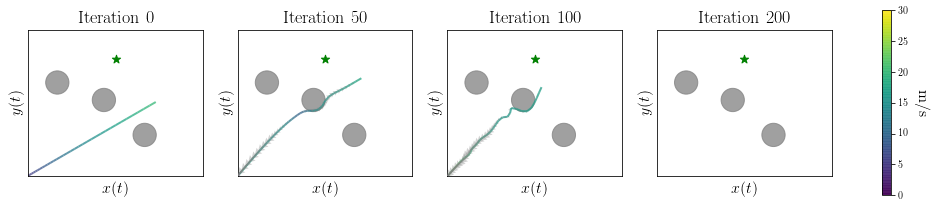

In [149]:
iterations = [0, 50, 100, 200]
fig, axes = plt.subplots(1, len(iterations))

data = {'ilqg': ilqg_data_top, 'hji': hji_data_top}

ilqg_line = None
hji_line = None
for i, axi in zip(iterations, axes):
    axi.set_aspect('equal')
    ilqg_line, hji_line = plot_iteration(axi, i, data, downsample=3)
        
if ilqg_line is not None:
    bar = fig.colorbar(ilqg_line, ax=axes.ravel().tolist())
    bar.ax.set_ylabel('m/s', rotation=270, labelpad=24, fontsize=16)

fig.set_figwidth(4 * len(iterations) + 2)
fig.set_figheight(3.4)
plt.savefig('plots/two_player_zero_sum_top.pdf', bbox_inches='tight')

## Bottom figure

In [ ]:
fig, axes = plt.subplots(1, len(iterations))

data = {'ilqg': ilqg_data_bottom, 'hji': hji_data_bottom}

ilqg_line = None
hji_line = None
for i, axi in zip(iterations, axes):
    axi.set_aspect('equal')
    ilqg_line, hji_line = plot_iteration(axi, i, data, downsample=3)
        
if ilqg_line is not None:
    bar = fig.colorbar(ilqg_line, ax=axes.ravel().tolist())
    bar.ax.set_ylabel('m/s', rotation=270, labelpad=24, fontsize=16)
    
plt.legend((Line2D([0], [0], color='b', linestyle='--'),), 
           ('HJI',),
          loc='lower right',
          fontsize=16,
          framealpha=0,
          bbox_to_anchor=(1.05, -0.05))

fig.set_figwidth(4 * len(iterations) + 2)
fig.set_figheight(3.4)
plt.savefig('plots/two_player_zero_sum_bottom.pdf', bbox_inches='tight')

In [ ]:
# fig, axes = plt.subplots(3, len(iterations))

# downsample = 1

# for ii in range(len(iterations)):
#     ilqg_us = ilqg_data['us'][iterations[ii]][0]
    
#     # TODO: Add plots from the HJI 
    
#     ilqg_omeg = [u[0, 0] for k, u in enumerate(ilqg_us) if k % downsample == 0]
#     ilqg_accs = [u[1, 0] for k, u in enumerate(ilqg_us) if k % downsample == 0]
#     ts = [T * k for k in range(len(ilqg_us)) if k % downsample == 0]
    
#     # Plot ILQG/HJI acceleration control input.
#     axes[0, ii].plot(ts, ilqg_accs)
#     axes[0, ii].set_xlabel('$t$ (s)', fontsize=16)
#     axes[0, ii].set_ylabel('$a(t)$ (m/s/s)', fontsize=16)
    
#     # Plot the ILQG/HJI angular velocity control input.
#     axes[1, ii].plot(ts, ilqg_omeg)
#     axes[1, ii].set_xlabel('$t$ (s)', fontsize=16)
#     axes[1, ii].set_ylabel('$\omega(t)$ (rad/s)', fontsize=16)
    
#     ilqg_ds = ilqg_data['us'][iterations[ii]][1]
    
#     ilqg_dvxs = [u[0, 0] for k, u in enumerate(ilqg_ds) if k % downsample == 0]
#     ilqg_dvys = [u[1, 0] for k, u in enumerate(ilqg_ds) if k % downsample == 0]
    
#     # Plot the ILQG/HJI disturbance inputs. 
#     axes[2, ii].plot(ts, ilqg_dvxs)
#     axes[2, ii].plot(ts, ilqg_dvys)
#     axes[2, ii].set_xlabel('$t$ (s)', fontsize=16)
#     axes[2, ii].set_ylabel('$\d_1(t), d_t')
    
# fig.set_figwidth(4 * len(iterations) + 2)
# fig.set_figheight(12)
# plt.savefig('plots/two_player_zero_sum_ctrl_dstb.pdf', bbox_inches='tight')

# Three Player General Sum

In [140]:
# Load the ILQG data.
fp = open('../python/logs/three_player/intersection_car_example.pkl', 'rb')
three_player_data = dill.load(fp)
fp.close()

In [5]:
player_goals = [(6, 30), (20, 12), (15, 18)]
player_xy_indices = [(0, 1), (5, 6), (10, 11)]
player_rot_indices = [2, 7, 12]
goal_radii = [1.5, 1.5, 1.5]
player_colors = [(179/255, 0, 0, 1),
                 (0, 179/255, 0, 1), 
                 (0, 0, 179/255, 1)]
player_labels = ['Player 1', 'Player 2', 'Player 3']

In [6]:
def plot_three_player_goals(ax):
    for ii, goal in enumerate(player_goals):
        circle = plt.Circle(
            (goal[0], goal[1]), goal_radii[ii], color=player_colors[ii], fill=True, alpha=0.5)
        ax.add_artist(circle)

In [47]:
def plot_three_player_costs(ax):
    # Plot player 1 path.
    player1_path_xs = [6, 6]
    player1_path_ys = [-100, 100]
    
    lines = ax.plot(player1_path_xs, 
                    player1_path_ys, 
                    color=(204/255, 204/255, 204/255, 1.), 
                    alpha=0.5,
                    linewidth=25,
                    zorder=0)
    
    # Plot player 2 path.
    player2_path_xs = [2, 2, 2.5, 3, 5, 8, 100]
    player2_path_ys = [100, 18, 15, 14, 12.5, 12, 12]
    
    ax.plot(player2_path_xs, 
            player2_path_ys, 
            color=(204/255, 204/255, 204/255, 1.), 
            alpha=0.5,
            linewidth=25,
            zorder=0)

    # Plot player 3 path (crosswalk).
    player3_crosswalk_xs = [-3, 0, 3, 6, 9, 12]
    player3_crosswalk_ys = [18, 18, 18, 18, 18, 18]
    
    crosswalk_width = 2
    crosswalk_height = 4
    
    for x, y in zip(player3_crosswalk_xs, player3_crosswalk_ys):
        rect = plt.Rectangle((x - crosswalk_width / 2, 
                              y - crosswalk_height / 2), 
                             crosswalk_width,
                             crosswalk_height, 
                             fill=True, 
                             color=(255/255, 255/255, 153/255, 1.), 
                             alpha=0.5,
                             zorder=0)
        ax.add_artist(rect)

In [119]:
def plot_player_at(ax, player_idx, x, y, rot, scale=1., alpha=1., label=True):
    unit_tri = Path.unit_regular_polygon(3)
        
    path = Path(unit_tri.vertices * np.array([[1.75], [1], [1], [1.75]]) * scale, unit_tri.codes)
    trans = Affine2D().translate(x, y).rotate_around(x, y, rot)
    
    player_label = None
    if label:
        player_label = player_labels[player_idx]
        
    patch = PathPatch(
        path.transformed(trans), facecolor=player_colors[player_idx], label=player_label, alpha=alpha)
    ax.add_patch(patch)

In [146]:
def filter_three_player_traj(xs_in, ys_in, rot_in, thresh=0.5):
    last_x = np.inf
    last_y = np.inf
    
    xs_out = []
    ys_out = []
    rot_out = []
    
    for ii in range(len(xs_in)):
        x = xs_in[ii]
        y = ys_in[ii]
        rot = rot_in[ii]
        if np.sqrt((x - last_x) ** 2 + (y - last_y) **2) > thresh:
            xs_out.append(x)
            ys_out.append(y)
            rot_out.append(rot)
        
        last_x = x
        last_y = y
    
    return xs_out, ys_out, rot_out

def plot_three_player_segment(ax, segment, xlabel='$x(t)$', ylabel='$y(t)$', faded_segment=None):
    ax.set_title('${} \leq t \leq {}$'.format(T * segment[0],
                                              T * segment[1]), fontsize=24)
    
    # Plot the goals.
    plot_three_player_goals(ax)
    
    # Plot the costs.
    plot_three_player_costs(ax)
    
    # Plot the trajectory (from the final iteration).
    traj = three_player_data['xs'][-1].copy()
    for ii, idx in enumerate(player_xy_indices):
        xs = [w[idx[0]] for w in traj[segment[0]:segment[1]]]
        ys = [w[idx[1]] for w in traj[segment[0]:segment[1]]]
        rots = [w[player_rot_indices[ii]] for w in traj[segment[0]:segment[1]]]
        
        # TODO: Hack! (But works for the sake of the paper deadline)
        if ii == 1:
            xs, ys, rots = filter_three_player_traj(xs, ys, rots)
            
        ax.plot(xs, ys, c=player_colors[ii])
        
        final_x = xs[-1]
        final_y = ys[-1]
        final_rot = rots[-1] - 0.5 * np.pi
        plot_player_at(ax, ii, final_x, final_y, final_rot, scale=1.)
        
        if faded_segment is not None:
            ax.plot([w[idx[0]] for w in traj[faded_segment[0]:faded_segment[1]]],
                    [w[idx[1]] for w in traj[faded_segment[0]:faded_segment[1]]],
                    c=player_colors[ii],
                    alpha=0.25,
                    label=None)
            
            final_x = traj[faded_segment[1] - 1][player_xy_indices[ii][0]]
            final_y = traj[faded_segment[1] - 1][player_xy_indices[ii][1]]
            final_rot = traj[faded_segment[1] - 1][player_rot_indices[ii]] - 0.5 * np.pi
            plot_player_at(ax, ii, final_x, final_y, final_rot, scale=1., alpha=0.25, label=False)
    
    ax.set_xlim([-5, 25])
    ax.set_ylim([-5, 35])
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

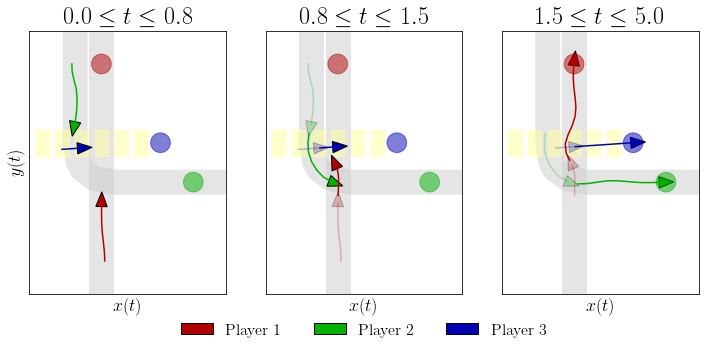

In [147]:
iteration_segments = [(0, 8), (8, 15), (15, 50)]
fig, axes = plt.subplots(1, len(iteration_segments))

for ii, axi in enumerate(axes):
    ylabel = '$y(t)$'
    if ii > 0:
        ylabel = ''
        
    faded_segment = None
    if ii > 0:
        faded_segment = iteration_segments[ii - 1]
        
    plot_three_player_segment(axi, iteration_segments[ii], ylabel=ylabel, faded_segment=faded_segment)
    axi.set_aspect('equal')

axes[1].legend(loc='lower center',
                fontsize=16,
                framealpha=0,
                bbox_to_anchor=(0.5, -0.225),
                ncol=3) # To make the legend horizontal.
    
fig.set_figwidth(4 * len(iteration_segments))
fig.set_figheight(5)
plt.savefig('plots/three_player_example.pdf', bbox_inches='tight')

# Front Figure

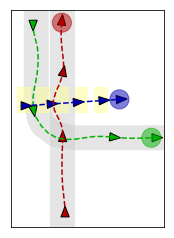

In [51]:
fig = plt.figure()

ax = fig.gca()

# Plot the goals.
plot_three_player_goals(ax)

# Plot the costs.
plot_three_player_costs(ax)
    
# Plot the trajectory (from the final iteration).
traj = three_player_data['xs'][-1]
for ii, idx in enumerate(player_xy_indices):
    ax.plot([w[idx[0]] for w in traj],
            [w[idx[1]] for w in traj],
            c=player_colors[ii],
            linestyle='dashed')

arrow_every_k = 5
for ii in range(len(player_rot_indices)):
    last_x = np.inf
    last_y = np.inf
    for jj in range(int(len(traj) / arrow_every_k)):
        idx = min(jj * 10, len(traj) - 1)
        x = traj[idx][player_xy_indices[ii][0]]
        y = traj[idx][player_xy_indices[ii][1]]
        rot = traj[idx][player_rot_indices[ii]] - 0.5 * np.pi
        if np.sqrt((x - last_x) ** 2 + (y - last_y) **2) > 0.5:
            plot_player_at(ax, ii, x, y, rot, scale=0.75)
            
        last_x = x
        last_y = y

ax.set_xlim([-2, 22])
ax.set_ylim([-2, 32])
# ax.set_xlabel('$x(t)$', fontsize=18)
# ax.set_ylabel('$y(t)$', fontsize=18)
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

# fig.set_figwidth(5)
# fig.set_figheight(5.5)
plt.savefig('plots/three_player_front_fig.pdf', bbox_inches='tight')